# **Failing to Success: Support Vector Machine**





As a first step, we import the training data as well as all the needed libraries: 

In [223]:
# import standard python libraries
import os, urllib, io
from datetime import datetime
import numpy as np

# import the PyTorch deep learning libary
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim

# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

# import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# import the Google Colab GDrive connector
from google.colab import drive

#import pandas
import pandas as pd


# mount GDrive inside the Colab notebook
drive.mount('/content/drive')

# create Colab Notebooks directory
notebook_directory = '/content/drive/MyDrive/Colab Notebooks'
if not os.path.exists(notebook_directory): os.makedirs(notebook_directory)

 # create data sub-directory inside the Colab Notebooks directory
data_directory = '/content/drive/MyDrive/Colab Notebooks/data'
if not os.path.exists(data_directory): os.makedirs(data_directory)

 # create models sub-directory inside the Colab Notebooks directory
models_directory = '/content/drive/MyDrive/Colab Notebooks/models'
if not os.path.exists(models_directory): os.makedirs(models_directory)

# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

train_path = data_directory + 'train_fashion_mnist'

# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download and transform training images
fashion_mnist_train_data = torchvision.datasets.FashionMNIST(root=train_path, train=True, transform=transf, download=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[LOG] notebook with cpu computation enabled


In [224]:
# import the numpy, scipy and pandas data science library
import numpy as np
import scipy as sp
from scipy.stats import norm

# import sklearn data and data pre-processing libraries
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# import torchvision library
import torchvision

# import sklearn HOG feature library
from skimage.feature import hog

# import sklearn support vector classifier (svc) library
from sklearn.svm import SVC

# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

# import matplotlib data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

#import further libraries and functions
import torchvision.transforms as transforms
import torchvision.datasets as dsets

So far all pixel values of a picture are in one clomun. So we make a  list for all pixel tensors, and a list for for the labels. Further we define a dictionary to afterwords replace the numeric labels through words to directly know which category a picture belongs to:



In [225]:
#giving names ("strings") to the fashion classes
fashion_classes = {0: 'T-shirt/top',
                    1: 'Trouser',
                    2: 'Pullover',
                    3: 'Dress',
                    4: 'Coat',
                    5: 'Sandal',
                    6: 'Shirt',
                    7: 'Sneaker',
                    8: 'Bag',
                    9: 'Ankle boot'}

#creating a list with the labels corresponding to the training dataset, 
# this seperates the labels from the dataset
x= []
for i in range(len(fashion_mnist_train_data)):
  x.append(fashion_classes[fashion_mnist_train_data[i][1]])


In [226]:
#creating a list with the different pixel tensors,
#this seperates the exogeneous variables from the training dataset
y= []
for i in range(len(fashion_mnist_train_data)):
  y.append(fashion_mnist_train_data[i][0])

Here we create a dataframe with the exogeneous variables in the column "Pixels" and the endogeneous variables in the column "Label":

In [227]:
#creating a dataframe with the exogeneous variables in the column "Pixels"
#and the endogeneous variables in the column "Label"
d = {'Pixels':y,'Label':x}
train = pd.DataFrame(d)


Now we use that data frame to create another data frame in which every pixel has its own column. This way every single pixel works as one feature on its own:

In [228]:
#creating an empty df in which we can input each pixel value of a picture in a column 
columns=list(range(784))

emptydf=pd.DataFrame(data= np.nan,    # values
             index=list(range(len(train))),    # 1st column as index
             columns=columns)  # 1st row as the column names


In [229]:
# plugging each individual value from the tensors into a column

df2=train.iloc[:,0]

for i in range(len(train)):
  q=df2[i][0]
  a= q.tolist()

  flat_list = []
  for sublist in a:
      for item in sublist:
          flat_list.append(item)
  emptydf.iloc[i,:]=flat_list






Here we add the corresponding labels of the pictures to the dataframe: 


In [230]:
#we add the endogenous variables(labels), to the exogeneous variables(pixels) 
#and assign that df to the variable train
train = emptydf.assign(label = x)


We create train_unchanged to have one train dataset that we never change to be able to use it later on if the original dataset is needed:

In [231]:
train_unchanged=train.copy()

Now we investigate the distribution of the data. The function "count_classes" should give out a plot of the classes inside a series and also a tabel with the count of how many time each class appears in the series:

In [232]:
def count_classes (series):
  elements= set(series)
  series_out = pd.Series(0,index=elements)
  for i in series:
    series_out[i]=series_out[i]+1
  plot_out=plt.bar(series_out.index, series_out.values, width=0.2,  align='center' )
  plt.title('Distibution of classes')
  plt.xlabel('classes')
  return series_out,plot_out

(Dress          6000
 Coat           6000
 Sneaker        6000
 Pullover       6000
 Trouser        6000
 Ankle boot     6000
 Shirt          6000
 Bag            6000
 Sandal         6000
 T-shirt/top    6000
 dtype: int64, <BarContainer object of 10 artists>)

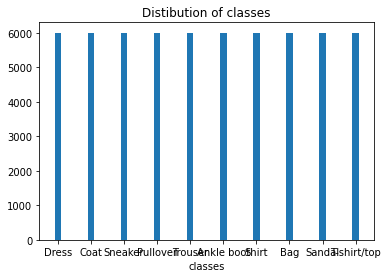

In [233]:
count_classes(train["label"])

As shown, the data in the training set is perfectly balanced. We go one step further and create a copy of the dataframe and add two more columns to it one "mean_pixelvalue" giving us the mean of the pixelvalue in the picture. The other additional column "zeroval" gives of the number of pixels = 0 there are in the picture:

In [234]:
train_extended=train.copy()
#adding a coulumn giving us the mean pixel value of the pictures
train_extended["mean_pixelvalue"]=train_extended.mean(axis=1)

In [235]:
#counting the number of pixelsvalues = 0 in each row(picture)
zeroval=[]
for i in range(len(train_extended)):
  counter=list(train_extended.iloc[i,:784]).count(0)  
  zeroval.append(counter)

#create zeroval column
train_extended["zeroval"]=zeroval

Now we group by label and take the mean to get the overall mean of pixelvalues and pixel=0 for each class:

In [236]:
mean_by_label=train_extended.groupby(["label"]).mean()

We investigate how the number of pixels=0 are distributed in each class and what mean for average of pixel = 0 there is in each class:

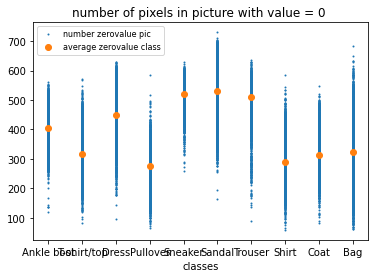

In [237]:
plt.scatter((train_extended["label"]), train_extended["zeroval"], s=1)
plt.scatter(mean_by_label.index,mean_by_label["zeroval"])
plt.title('number of pixels in picture with value = 0 ')
plt.xlabel('classes')
plt.legend(["number zerovalue pic", "average zerovalue class"],loc="upper left", fontsize=8)

We investigate how the average pixelvalues are distributed in each class and what mean for average pixelvalue there is in each class:

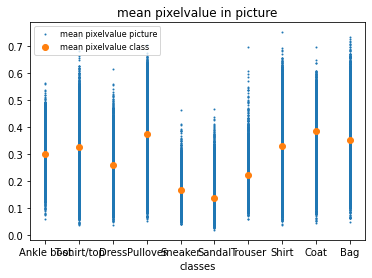

In [238]:
plt.scatter((train_extended["label"]), train_extended["mean_pixelvalue"], s=1)
plt.scatter(mean_by_label.index,mean_by_label["mean_pixelvalue"])
plt.title('mean pixelvalue in picture')
plt.xlabel('classes')
plt.legend(["mean pixelvalue picture", "mean pixelvalue class"],loc="upper left",fontsize=8)

As shown in the graphs there is some variance between the classes regarding the number of 0-pixels and the average pixel value. These information will be used later on in the code. 

For now we continue with the normal training set. As we will train a SVM which  takes up a lot of computing power with bigger datasets without 
improving much the perfomance, we chose to only use the first 20'000 pictures:

In [239]:
train= train.iloc[:20000,:]

Before we get started, lets see if also the subset of the training data used is balanced:

(Dress          2011
 Coat           1967
 Sneaker        2003
 Pullover       1982
 Trouser        2025
 Ankle boot     2028
 Shirt          2068
 Bag            1971
 Sandal         2010
 T-shirt/top    1935
 dtype: int64, <BarContainer object of 10 artists>)

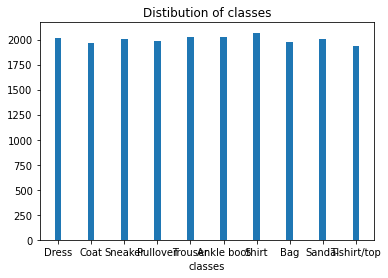

In [240]:
count_classes(train["label"])

The subset we are using is well suited for training as there is a more or less an equal distribution of pictures of different classes.  

# Training a basic (linear) Support Vector Machine 

First we do a training and testing split and set the random seed in order to have replicable results:

In [241]:
eval_fraction = 0.3
random_seed = 42
# 70% training and 30% evaluation
x_train, x_eval, y_train, y_eval = train_test_split(train.iloc[:,0:784], train.loc[:,"label"], test_size=eval_fraction, random_state=random_seed, stratify=None)

Now we train an untuned SVM to see with what an accuracy rate we start off:

In [242]:
svm_linear = SVC(kernel='linear', random_state=random_seed)
svm_linear.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [243]:
#Prediction
y_pred_linear = svm_linear.predict(x_eval)

In [244]:
#Performance
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(y_eval, y_pred_linear) * 100)))
print('Number of mislabeled pictures out of a total {} pictures: {}'.format(x_eval.shape[0], np.sum(y_eval != y_pred_linear)))

Model classification accuracy: 83.46666666666667%
Number of mislabeled pictures out of a total 6000 pictures: 992


An Accuracy rate of nearly 83.5% for an untuned model is already pretty good. This will mainly be due to our one-pixel-one-feature approach while data cleaning. The confusion matrix below illustrates the result in more detail:

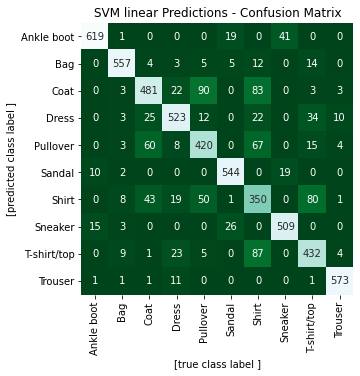

In [245]:
#confusion matrix
# determine the prediction confusion matrix
labelnames = ['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt/top',
 'Trouser']


mat = confusion_matrix(y_eval, y_pred_linear)

# init the plot
plt.figure(figsize=(5, 5))

# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r',xticklabels=labelnames, yticklabels=labelnames )

# add plot axis labels
plt.xlabel('[true class label ]')
plt.ylabel('[predicted class label ]')

# add plot title
plt.title('SVM linear Predictions - Confusion Matrix');

Now as we now what base accuracy is achievable, we try to improve it through taking several different approaches.

# Training a basic Support Vector Machine (rbf)

Here we are going to use the same train/test split as above. However we are going to change the kernel function used by the SVM. What best improved our performance was to not use a linear kernel but the rbf kernel. With the **Radial Basis Function (RBF)**, the distance of a training sample to the to-be-classified sample is relevant in determining how much influence a training sample point has on the classificatoin of a to-be-classified sample. This way the RBF weighs the influence of the training samples on the classification of a new observation according to how far away a training point is from the new observation. Due to that it actually works similair as the KNN algorithm.

Source: https://towardsdatascience.com/radial-basis-function-rbf-kernel-the-go-to-kernel-acf0d22c798a

In [246]:
#training the SVM with the "rbf" method
svm_rbf = SVC(kernel='rbf', random_state=random_seed)
svm_rbf.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

After the model is trained we run predictions and evaluate the performace with the accuracy rate and the number of pictures mislabeled:

In [247]:
#Prediction
y_pred = svm_rbf.predict(x_eval)

In [248]:
#Performance
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(y_eval, y_pred) * 100)))
print('Number of mislabeled pictures out of a total {} pictures: {}'.format(x_eval.shape[0], np.sum(y_eval != y_pred)))



Model classification accuracy: 86.95%
Number of mislabeled pictures out of a total 6000 pictures: 783


With the rbf kernel our accuracy rate got significantly better than with the linear kernel. Therefore, we decided to continue using the rbf kernel throughout our project. As before, here we  created the confusion matrix to further investigate the results:

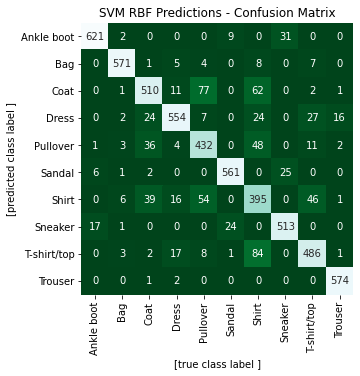

In [249]:
# determine the prediction confusion matrix
labelnames = ['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt/top',
 'Trouser']


mat = confusion_matrix(y_eval, y_pred)

# init the plot
plt.figure(figsize=(5, 5))

# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r',xticklabels=labelnames, yticklabels=labelnames )

# add plot axis labels
plt.xlabel('[true class label ]')
plt.ylabel('[predicted class label ]')

# add plot title
plt.title('SVM RBF Predictions - Confusion Matrix');

# Stacking
We have seen that our SVM above was good to recognize certain classes, however often had problems to differentiate between other classes. To further improve our performance, we decided to bundle the classes which the SVM was bad at recognizing correctly so far.

The idea is that we first run an SVM that identifies the classes which it can easily recognize and isolates the classes that are often misclassified. Afterwards, a second SVM (trained only on the classes that are often being mixed up) tries to differentiate between the classes our first model often mixed up.

Therefore, we bundled the following classes together to the category 'Clothing':
- shirt
- pullover
- coat
- dress
- t- shirt

as the SVM above had difficulties to differentiate between them, and a 'specialized' SVM focusing only on differentiating these classes from each other might be more successful which could result in a higher performance. 



First we therefore copied the training set to change the labels:


In [250]:
#creating a second training dataset for this approach to be able to better differentiate
label_original=train.loc[:,"label"]
train_original=train
train2=train.copy()

Here we changed the labels of the aforementioned classes:

In [251]:
#reducing the number of classes by bundling the classes with high misclassification 
fashion_classes2 = { 'T-shirt/top': "Clothing",
                    'Trouser': "Trouser",
                    'Pullover': "Clothing",
                    'Dress': "Clothing",
                    'Coat': "Clothing",
                    'Sandal': "Sandal",
                    'Shirt': "Clothing",
                    'Sneaker': "Sneaker",
                    'Bag': "Bag",
                    'Ankle boot':"Ankle boot"}


train1 = train.copy()
for i in range(len(train1)):
  train1.loc[i,"label"]=fashion_classes2[train1.loc[i,"label"]]



Now we proceeded the same as before, with a train-test split, training the SVM and afterwards evaluating its performance:

In [252]:
#creating a training and testing split
eval_fraction = 0.3
random_seed = 42
# 70% training and 30% evaluation
x_train1, x_eval1, y_train1, y_eval1 = train_test_split(train1.iloc[:,0:784], train1.loc[:,"label"], test_size=eval_fraction, random_state=random_seed, stratify=None)

In [253]:
#we train a first linear SVC model of on the clustered classes 
svm1 = SVC(kernel='rbf', random_state=random_seed)
svm1.fit(x_train1, y_train1)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [254]:
#Prediction
y_pred1 = svm1.predict(x_eval1)

In [255]:
#Performance
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(y_eval1, y_pred1) * 100)))
print('Number of mislabeled points out of a total {} points: {}'.format(x_eval1.shape[0], np.sum(y_eval1 != y_pred1)))



Model classification accuracy: 97.01666666666667%
Number of mislabeled points out of a total 6000 points: 179


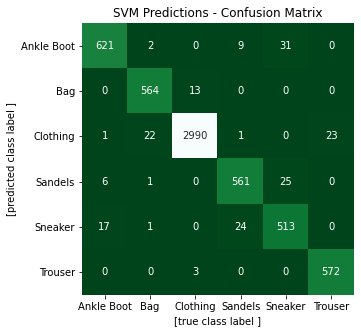

In [256]:
# determine the prediction confusion matrix
labelnames = ['Ankle Boot', 'Bag',"Clothing", 'Sandels','Sneaker',"Trouser"]

mat = confusion_matrix(y_eval1, y_pred1)

# init the plot
plt.figure(figsize=(5, 5))

# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r',xticklabels=labelnames, yticklabels=labelnames )

# add plot axis labels
plt.xlabel('[true class label ]')
plt.ylabel('[predicted class label ]')

# add plot title
plt.title('SVM Predictions - Confusion Matrix');

As one can see, the model is able to seperate the clustered class "Clothing" and predict the other clothing articles extremely well. However, with this model we still need to further be able to differentiate between the individual classes within our class 'Clothing'. Therefore we first created a dataset which only includes the pictures which are of the class Clothing:


In [257]:
train_cloth = train_unchanged[train_unchanged['label'] != 'Trouser']
train_cloth = train_cloth[train_cloth['label'] != 'Sandal']
train_cloth = train_cloth[train_cloth['label'] != 'Sneaker']
train_cloth = train_cloth[train_cloth['label'] != 'Bag']
train_cloth = train_cloth[train_cloth['label'] != 'Ankle boot']

len(train_cloth)

30000

To train our Clothing-SVM, we run through the same steps as before. However, as this are the classes which are the hardest to seperate, we decided to use all available data for training, meaning all 30'000 pictures in the training data set, which belong to one of the following clothing classes: dress, pullover, coat, shirt or T-shirt/top. Therefore this SVM  will be tested on the data it has already seen, and later on when we bring the models together we will run the full algortithm on testing data.

In [258]:
#actual model
svm2 = SVC(kernel='rbf', random_state=random_seed) 
svm2.fit(train_cloth.iloc[:,:784], train_cloth.loc[:,"label"])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [259]:
#Prediction
y_pred2 = svm2.predict(train_cloth.iloc[:,:784])

In [260]:
#Performance
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score( train_cloth.loc[:,"label"], y_pred2) * 100)))
print('Number of mislabeled points out of a total {} points: {}'.format(train_cloth.iloc[:,:784].shape[0], np.sum(train_cloth.loc[:,"label"] != y_pred2)))

Model classification accuracy: 85.49333333333334%
Number of mislabeled points out of a total 30000 points: 4352


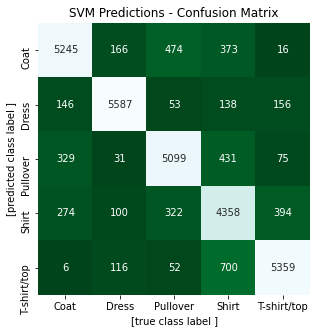

In [261]:
# determine the prediction confusion matrix
labelnames = ['Coat', 'Dress', "Pullover", 'Shirt', 'T-shirt/top']

mat = confusion_matrix(train_cloth.loc[:,"label"], y_pred2)

# init the plot
plt.figure(figsize=(5, 5))

# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r',xticklabels=labelnames, yticklabels=labelnames )

# add plot axis labels
plt.xlabel('[true class label ]')
plt.ylabel('[predicted class label ]')

# add plot title
plt.title('SVM Predictions - Confusion Matrix');

The performacne of the rbf kernel is decent when it come to seperate between the clothing classes (based on the training data). Therefore, we now finally create a function, that uses first an SVM Model to classify the pictures into the classes Trouser, Ankle Boot, Bag, Sneaker, Sandal and Clothing, and a second SVM Model which split the predicitons Clothing into the classes Pullover, Dress, Coat, Shirt and T-shirt/top. 

In [262]:
def classification(data):
  output=[]
  for i in range(len(data)):
    pic=data.iloc[i:i+1,:784]
    result=svm1.predict(pic)[0]
    if result=="Clothing":
      result=svm2.predict(pic)[0]
    output.append(result)

  return output

To check the performance on the training data, we are going to run the function on the x_train data set. Here we have the final labels (not as with the x_train1, as there we have the class 'Clothing'). Further, as we set the same seed, this data is the same as the x1_train data used to train the svm1 model (just that there some labels were changed). The svm2 model used all samples in the training data set which are relevant for the purpose of the svm2, therefore it also has already seen the pictures which it will classify from x_train:

In [263]:
Pred_train=classification(x_train)
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(y_train, Pred_train) * 100)))

Model classification accuracy: 90.52857142857142%


Our **Accuracy on the Training Data is 90.5%.** Let's now see what accuracy we can achieve on the evaluation data.

## Evaluation Data
Same as the training data, the Evaluation Data also has all pixel values in one column. Therefore, the same cleaning approaches as with the training data will be applied.

In [264]:
IMAGE_SIZE = 28
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

validation_dataset = dsets.FashionMNIST(root='./data', train=False, download=True, transform=composed)

In [265]:
x= []
for i in range(len(validation_dataset)):
  x.append(fashion_classes[validation_dataset[i][1]])


y= []
for i in range(len(validation_dataset)):
  y.append(validation_dataset[i][0])

d = {'Pixels':y,'Label':x}
evalset = pd.DataFrame(d)

columns=list(range(784))

emptydf=pd.DataFrame(data= np.nan,    # values
             index=list(range(len(evalset))),    # 1st column as index
             columns=columns)  # 1st row as the column names

df2=evalset.iloc[:,0]

for i in range(len(evalset)):
  q=df2[i][0]
  a= q.tolist()

  flat_list = []
  for sublist in a:
      for item in sublist:
          flat_list.append(item)
  emptydf.iloc[i,:]=flat_list


evalset = emptydf.assign(label = x)



Finally, we can now run our basic SVM Model on the evaluation data set:



In [266]:
pred_linear_eval = svm_linear.predict(evalset.iloc[:,:784])
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(evalset['label'], pred_linear_eval) * 100)))

Model classification accuracy: 83.03%


The basic linear model performed decent (83.03%), but let's compare this now to the basic rbf model:

In [267]:
Pred_rbf_eval = svm_rbf.predict(evalset.iloc[:,:784])
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(evalset['label'], Pred_rbf_eval) * 100)))

Model classification accuracy: 85.84%


With an Accuracy of 85.84% the performance on the evaluation data is already pretty good. Let's now try out our more advanced model on the evaluation data and see if we can improve the performance:

In [268]:
Pred_advanced_eval=classification(evalset.iloc[:,:784])
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(evalset['label'], Pred_advanced_eval) * 100)))

Model classification accuracy: 87.26%


The Accuracy on the Testing Data is 87.26%. Therefore, we were able to  improvement the performance through combining two Support Vector Machines.The confusion Matrix shown below illustrates the result in more detail:

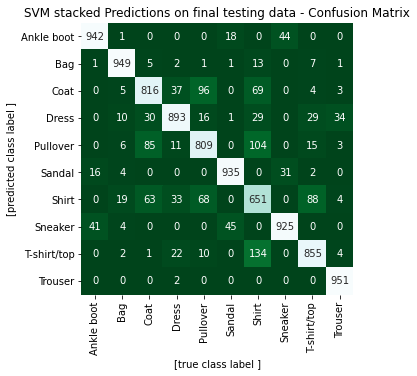

In [269]:
# determine the prediction confusion matrix
labelnames = ['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt/top',
 'Trouser']


mat = confusion_matrix(evalset['label'], Pred_advanced_eval)

# init the plot
plt.figure(figsize=(5, 5))

# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r',xticklabels=labelnames, yticklabels=labelnames )

# add plot axis labels
plt.xlabel('[true class label ]')
plt.ylabel('[predicted class label ]')

# add plot title
plt.title('SVM stacked Predictions on final testing data - Confusion Matrix');

#SVM on Extended Data

Now, as we have evaluated the first 'advanced' algorithm on the evaluation data, we continiue with another approach. Here we again use a basic SVM with a rbf kernel, but add the two columns (number of pixels= 0 and mean pixel value) as additional features to the data set.

First, we copy the train extended data set (which includes the necessary rows) and drop the label to create a data set with only the feature values:

In [270]:
#we create a copy to not change the original extended dataframe
train_extended_train=train_extended.copy()
train_extended_train=train_extended_train.drop(columns="label")

We normalise the zerovals as they are too big compared to the pixelvalues and are weighted too much because of that:

In [271]:
norm = [float(i)/sum(train_extended_train["zeroval"]) for i in train_extended_train["zeroval"]]
train_extended_train["zeroval"]=norm

Now we train the SVM on the extended data set:

In [272]:
random_seed=42
svm_extended = SVC(kernel='rbf', random_state=random_seed)
svm_extended.fit(train_extended_train.iloc[:20000,:], train_extended.loc[:19999,"label"])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [273]:
#we predict 10000 pictures
y_predict_extended=svm_extended.predict(train_extended_train.iloc[30000:40000,:])

In [274]:
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(train_extended.loc[30000:39999,"label"], y_predict_extended) * 100)))

Model classification accuracy: 87.96000000000001%


An accuracy rate of nearly 88% is very good! Therefore, we now tun it on the evaluation set:

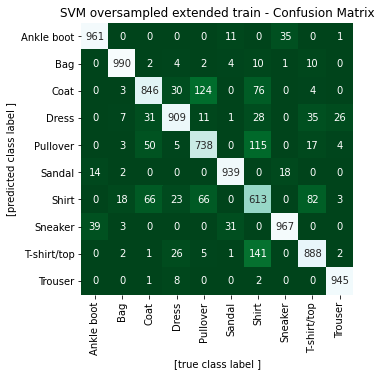

In [275]:
#confusion matrix
# determine the prediction confusion matrix
labelnames = ['Ankle boot',
'Bag',
'Coat',
'Dress',
'Pullover',
'Sandal',
'Shirt',
'Sneaker',
'T-shirt/top',
'Trouser']
mat = confusion_matrix(train_extended.loc[30000:39999,"label"], y_predict_extended)
# init the plot
plt.figure(figsize=(5, 5))
# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r',xticklabels=labelnames, yticklabels=labelnames )
# add plot axis labels
plt.xlabel('[true class label ]')
plt.ylabel('[predicted class label ]')
# add plot title
plt.title('SVM oversampled extended train - Confusion Matrix');


## Evaluation Data

First we have to extend the evaluation data with the additional features in order to be able to test our extended svm on it:

In [276]:
evalset_extended = evalset.copy()

In [277]:
#adding the mean of the pixel values to the column "mean_pixelvalue"
evalset_extended["mean_pixelvalue"]=evalset_extended.mean(axis=1)
#counting the number of pixelsvalues = 0 in each row(picture)
zeroval=[]
for i in range(len(evalset_extended)):
  counter=list(evalset_extended.iloc[i,:784]).count(0)  
  zeroval.append(counter)

#create zeroval column
evalset_extended["zeroval"]=[float(i)/sum(zeroval) for i in zeroval]


Now we see which performance the extended SVM gets us:

In [278]:
Pred_extended=svm_extended.predict(evalset_extended.drop(columns="label"))
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(evalset_extended['label'], Pred_extended) * 100)))

Model classification accuracy: 86.38%


An accuracy rate of 86.38% is actually slightly below the performance of our stacked SVM (87.26%), however it is above the performance of the basic SVM with a rbf kernel (85.84%). Therefore, the extended training data (namely the additional two features) seem to be helpful for classifying the pictures. Therefore, in the *mash up approach* we will combine the stacked approach (our best algorithm) with the extended data set. Strictly speacking, we will stack two SVMs as done before, however now they are trained on the extended data set.

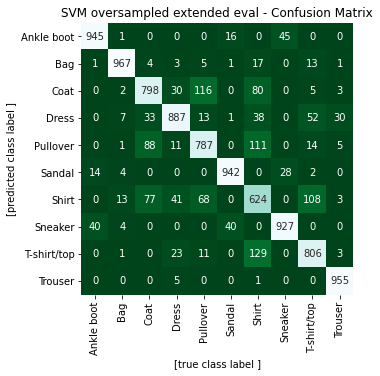

In [279]:
#confusion matrix
# determine the prediction confusion matrix
labelnames = ['Ankle boot',
'Bag',
'Coat',
'Dress',
'Pullover',
'Sandal',
'Shirt',
'Sneaker',
'T-shirt/top',
'Trouser']
mat = confusion_matrix(evalset_extended['label'], Pred_extended)
# init the plot
plt.figure(figsize=(5, 5))
# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r',xticklabels=labelnames, yticklabels=labelnames )
# add plot axis labels
plt.xlabel('[true class label ]')
plt.ylabel('[predicted class label ]')
# add plot title
plt.title('SVM oversampled extended eval - Confusion Matrix');


# Oversampling
As another approach instead of stacking done before, we try to solve the problem with the "hard to classify" classes  through oversampling:

In [280]:
training_unbal=train_unchanged.copy()
training_unbal=training_unbal.iloc[:50000,:]

Tshirt_top= training_unbal.loc[training_unbal['label'] == "T-shirt/top"]
Trouser= training_unbal.loc[training_unbal['label'] == "Trouser"]
Pullover= training_unbal.loc[training_unbal['label'] == "Pullover"]
Dress= training_unbal.loc[training_unbal['label'] == "Dress"]
Coat= training_unbal.loc[training_unbal['label'] == "Coat"]
Sandal= training_unbal.loc[training_unbal['label'] == "Sandal"]
Shirt= training_unbal.loc[training_unbal['label'] == "Shirt"]
Sneaker= training_unbal.loc[training_unbal['label'] == "Sneaker"]
Bag= training_unbal.loc[training_unbal['label'] == "Bag"]
Ankle_boot= training_unbal.loc[training_unbal['label'] == "Ankle boot"]

We want to have more of the shirt, tshirt, and pullover class as those 
were highly misclassified:

In [281]:
training_unbal = pd.concat([Tshirt_top.iloc[:4000,:],Pullover.iloc[:4000,:],Shirt.iloc[:4000,:], Trouser.iloc[:2000,:],Dress.iloc[:2000,:],Coat.iloc[:2000,:],
               Sandal.iloc[:2000,:],Sneaker.iloc[:2000,:],Bag.iloc[:2000,:],Ankle_boot.iloc[:2000,:]])


Let's now illustrate the distibution of the oversampled data set:

(Dress          2000
 Coat           2000
 Sneaker        2000
 Pullover       4000
 Trouser        2000
 Shirt          4000
 Bag            2000
 Ankle boot     2000
 Sandal         2000
 T-shirt/top    4000
 dtype: int64, <BarContainer object of 10 artists>)

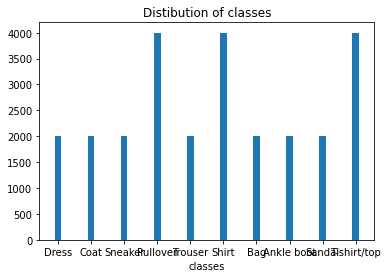

In [282]:
count_classes(training_unbal["label"])

Now we train an SVM on the oversampled data set and evaluate its performance:

In [283]:
#train model on unbalaned dataset
svm_unbal = SVC(kernel='rbf', random_state=random_seed)
svm_unbal.fit(training_unbal.iloc[:,:784], training_unbal["label"])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [284]:
#predict/test on initial balanced dataset
y_pred_unbal = svm_unbal.predict(train_unchanged.iloc[50001:,:784])

In [285]:
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(train_unchanged.loc[50001:,"label"], y_pred_unbal) * 100)))

Model classification accuracy: 87.51875187518752%


We see an improvement to 87.5% from the svm_rbf model (which was trained on the balanced dataset and scored 86.95% in accuracy on unseen training data). The confusion matrix looks as follows:

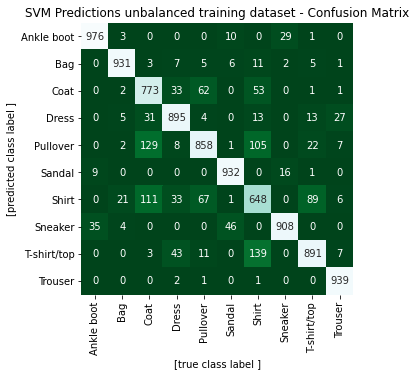

In [286]:
labelnames = ['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt/top',
 'Trouser']


mat = confusion_matrix(train_unchanged.loc[50001:,"label"], y_pred_unbal)

# init the plot
plt.figure(figsize=(5, 5))

# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r',xticklabels=labelnames, yticklabels=labelnames )

# add plot axis labels
plt.xlabel('[true class label ]')
plt.ylabel('[predicted class label ]')

# add plot title
plt.title('SVM Predictions unbalanced training dataset - Confusion Matrix');

## Evaluation Data

As the accuracy on unseen data from the training set was pretty high, therefore now we will check how well the svm_unbal performs on the FashionMNIST evaluation data set:

In [287]:
Pred_oversampling=svm_unbal.predict(evalset.iloc[:,:784])
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(evalset['label'], Pred_oversampling) * 100)))

Model classification accuracy: 86.61999999999999%


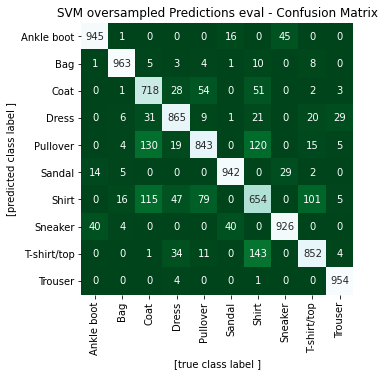

In [288]:
#confusion matrix
# determine the prediction confusion matrix
labelnames = ['Ankle boot',
'Bag',
'Coat',
'Dress',
'Pullover',
'Sandal',
'Shirt',
'Sneaker',
'T-shirt/top',
'Trouser']

mat = confusion_matrix(evalset['label'], Pred_oversampling)
# init the plot
plt.figure(figsize=(5, 5))
# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r',xticklabels=labelnames, yticklabels=labelnames )
# add plot axis labels
plt.xlabel('[true class label ]')
plt.ylabel('[predicted class label ]')
# add plot title
plt.title('SVM oversampled Predictions eval - Confusion Matrix');



Although the performance of the oversampling SVM is also better than the normal rbf algorithm, we decided against combining our stacking method with oversampling, as: the first algorithm of the stacking approach does hardly have any room for improvement (accuracy over 97%), whereas the second algorithm has already seen all available data which is relevant to seperarate between the clothing classes (all 30000 pictures used for training the svm2 model, and the other 30000 are not relevant to it as it is only about clothing classes).  



# Bundling into two clusters


With the stacking approach before having done so greatly, what we wanted to investigate in this part was: Is it possible to seperate two bundles of classes which themselves can easily be classified.

The idea/guess is if we are able to seperate the classes that are being misclassified among each other in seperate bundles we can in a second step easily classify the classes within the bundle. 

Maybe by clustering very different classes together the SVM can differentiate between them differently and circumvent the misclassification. Intuition wise this can be seen as somewhat the opposite appreach of the stacking done before. Instad of the first SVM differentiating between the easier to classify classes, here the first SVM seperates between the classes which are more similar, and the second SVM then seperates classes which are more different.

Trying to bundle labels together that are not being misclassified: 

In [289]:
#We bundle the classes which are not being misclassified among each other in the two clusters/groups "Mix1" and "Mix2"
fashion_classes3 = { 'T-shirt/top': "Mix1",
'Trouser': "Mix1",
'Pullover': "Mix2",
'Dress': "Mix1",
'Coat': "Mix2",
'Sandal': "Mix2",
'Shirt': "Mix2",
'Sneaker': "Mix2",
'Bag': "Mix1",
'Ankle boot':"Mix2"}

train_trial0 = train_unchanged.copy()
train_trial=train_trial0.iloc[:10000,:]

for i in range(len(train_trial)):
  train_trial.loc[i,"label"]=fashion_classes3[train_trial.loc[i,"label"]]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Now we train an SVM to be able to differentiate between Mix 1 and Mix2:

In [290]:
#training the svm that will seperate the clusters
svm_trial = SVC(kernel='rbf', random_state=random_seed)
svm_trial.fit(train_trial.iloc[:,:784], train_trial["label"])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Now we create two datasets only containing the classes of the two different clusters:

In [291]:
listofclasses1=["T-shirt/top","Trouser","Dress","Bag"]
listofclasses2=["Pullover","Sandal","Coat","Shirt","Sneaker","Ankle boot"]

mix1=train.iloc[:20000,:].copy()
mix2=train.iloc[:20000,:].copy()
for classes in listofclasses2:
  mix1=mix1[mix1["label"]!= classes]
for classes in listofclasses1:
  mix2=mix2[mix2["label"]!= classes]


The follwoing SVM will predict the precise classes within the bundle: Mix1:

In [292]:
#creating svm that can classify mix1 cluster
svm_mix1 = SVC(kernel='rbf', random_state=random_seed)
svm_mix1.fit(mix1.iloc[:,:784], mix1["label"])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Opposingly, this SVM will be trained to classify the specific classes in Mix2:

In [293]:
#creating svm that can classify mix2 cluster
svm_mix2 = SVC(kernel='rbf', random_state=random_seed)
svm_mix2.fit(mix2.iloc[:,:784], mix2["label"])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Having the three different SVM we now combine them to get the classifications of the pictures.


The first SVM (svm_trial) predicts whether the picture belongs to cluster one or two. The two latter SVMs (svm_mix1, svm_mix2), depending on which cluster was predicted, will predict the specific class of the pictures:

In [294]:
def cluster_predict(data):
  output=[]
  for i in range(len(data)):
    pic=data.iloc[i:i+1,:784]
    result=svm_trial.predict(pic)[0]
    if result=="Mix1":
      result=svm_mix1.predict(pic)[0]
    else:
      result=svm_mix2.predict(pic)[0]
    output.append(result)
  return output
  

In [295]:
#we take unknown data the svm models were not trained on as testing data
testsub=train_unchanged.iloc[50000:55000,:]
prediction_clustered= cluster_predict(testsub)

In [296]:
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(testsub["label"], prediction_clustered) * 100)))


Model classification accuracy: 86.32%


The accuracy is slightly worse than with the base rbf model (svm_rbf). The results will be illustrated in a confusion matrix down below. 

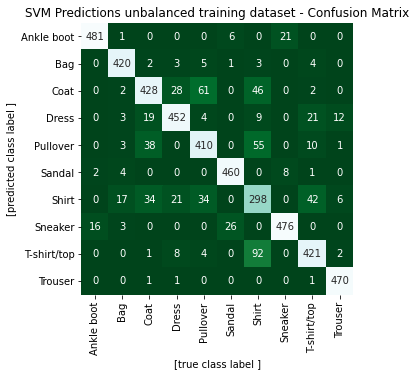

In [297]:
#names for axis
labelnames = ['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt/top',
 'Trouser']


mat = confusion_matrix(testsub["label"], prediction_clustered)

# init the plot
plt.figure(figsize=(5, 5))

# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r',xticklabels=labelnames, yticklabels=labelnames )

# add plot axis labels
plt.xlabel('[true class label ]')
plt.ylabel('[predicted class label ]')

# add plot title
plt.title('SVM Predictions unbalanced training dataset - Confusion Matrix');

The model did not improve in this case and our hypothesis that the misclassification can be circumevented by bundling classes together that are not misclassified is therefore probably wrong. Still, we will check how it performs on the evaluation data set:

# Evaluation data


In [298]:
Pred_cluster=cluster_predict(evalset.iloc[:,:784])
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(evalset['label'], Pred_cluster) * 100)))

Model classification accuracy: 85.39%


As also the performance on the evaluation data set was worse than the base rbf model (85.84%), we will not go further into details with this approach.

#Mashup

The best performances have come from stacking and extending the dataframe.
In order to get an even higher performance we will now combine those and run it on the evaluation data

Here, we first have to normalize the zeroval column as they have a totally different scale than the rest of the feature. Further, we adjust the extended training set throuhg bunsling the clothing classes into the class 'Clothing':

In [299]:
train_extended_final=train_extended.copy()

In [300]:
#we have to normalise the zerovalcolumn also for the training data
train_extended_final["zeroval"]=[float(i)/sum(zeroval) for i in train_extended_final["zeroval"]]


In [301]:
#reducing the number of classes by bundling the classes with high misclassification 
fashion_classes2 = { 'T-shirt/top': "Clothing",
                    'Trouser': "Trouser",
                    'Pullover': "Clothing",
                    'Dress': "Clothing",
                    'Coat': "Clothing",
                    'Sandal': "Sandal",
                    'Shirt': "Clothing",
                    'Sneaker': "Sneaker",
                    'Bag': "Bag",
                    'Ankle boot':"Ankle boot"}



for i in range(len(train_extended_final)):
  train_extended_final.loc[i,"label"]=fashion_classes2[train_extended_final.loc[i,"label"]]

Now, we use the first 20'000 pictures to train our SVM model:

In [302]:
train_extended_final=train_extended_final.iloc[:20000,:]

In [303]:
random_seed=42
x_train_ext=train_extended_final.drop(columns="label")

#we train a first linear SVC model of on the clustered classes 
svm1_ext = SVC(kernel='rbf', random_state=random_seed)
svm1_ext.fit(x_train_ext, train_extended_final["label"])


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Here, we start to train the second SVM model (the one which will seperte the clothing classes). For this, we again first normalize the zeroval feature, afterwards drop all pictures which do not belong to a clothing class, and train the SVM:

In [304]:
train_cloth_ext=train_extended.copy()
#also here normalise column "zeroval"
train_cloth_ext["zeroval"]=[float(i)/sum(zeroval) for i in train_cloth_ext["zeroval"]]
train_cloth_ext=train_cloth_ext.iloc[:60000,:]


In [305]:
train_cloth_ext = train_cloth_ext[train_extended['label'] != 'Trouser']
train_cloth_ext = train_cloth_ext[train_cloth_ext['label'] != 'Sandal']
train_cloth_ext = train_cloth_ext[train_cloth_ext['label'] != 'Sneaker']
train_cloth_ext = train_cloth_ext[train_cloth_ext['label'] != 'Bag']
train_cloth_ext = train_cloth_ext[train_cloth_ext['label'] != 'Ankle boot']

In [306]:
#actual model
x_train_ext2=train_cloth_ext.drop(columns="label")

svm2_ext = SVC(kernel='rbf', random_state=random_seed) 
svm2_ext.fit(x_train_ext2, train_cloth_ext["label"])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Similar to our stacking algorithm before, the followin function will combine the two SVMs which we trained now:

In [307]:
def classification_ext(data):
  output=[]
  for i in range(len(data)):
    pic=data.iloc[i:i+1,:]
    result=svm1_ext.predict(pic)[0]
    if result=="Clothing":
      result=svm2_ext.predict(pic)[0]
    output.append(result)

  return output

Let's see, how well our algorithm performs on training data:

In [314]:
train_extended_final_performance=train_extended.copy()
train_extended_final_performance=train_extended_final_performance.iloc[:10000,:]
train_extended_final_performance =train_extended_final_performance.drop(columns="label")
train_extended_final_performance["zeroval"]=[float(i)/sum(zeroval) for i in train_extended_final_performance["zeroval"]]

In [315]:
y_pred_mashup_train=classification_ext(train_extended_final_performance)

In [317]:
train_extended_trainperformance = train_extended.iloc[:10000,:]

In [318]:
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(train_extended_trainperformance["label"], y_pred_mashup_train) * 100)))

Model classification accuracy: 90.79%


The **Accuracy on 10'000 already seen training data is 90.79%** (best training accuracy achieved in whole code). This already indicates that our combination of the two algorithms was the right way to go. 

## Evaluation Data
Now, we directly predict the performance on the evaluation data:

In [308]:
test_mashup=evalset_extended.drop(columns="label")


In [309]:
y_pred_mashup=classification_ext(test_mashup)

In [310]:
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(evalset_extended["label"], y_pred_mashup) * 100)))

Model classification accuracy: 87.5%


The **Accuracy on the evaluation data is 87.5%** (the best testing data accuracy we achieved out of all algorithms). This way we can verify our hypothesis, that it made sense to combine our so far best performing models. The details of the result are specified in the confusion matrix down below:

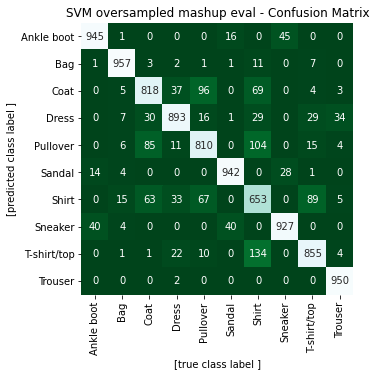

In [311]:
#confusion matrix
# determine the prediction confusion matrix
labelnames = ['Ankle boot',
'Bag',
'Coat',
'Dress',
'Pullover',
'Sandal',
'Shirt',
'Sneaker',
'T-shirt/top',
'Trouser']
mat = confusion_matrix(evalset_extended["label"], y_pred_mashup)
# init the plot
plt.figure(figsize=(5, 5))
# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r',xticklabels=labelnames, yticklabels=labelnames )
# add plot axis labels
plt.xlabel('[true class label ]')
plt.ylabel('[predicted class label ]')
# add plot title
plt.title('SVM oversampled mashup eval - Confusion Matrix');

# **Conclusion**


By separating each pixel of the pictures into one column we were able to reach a high accuracy. The best performance came from training a SVM only on the highly misclassified classes and stacking it with another SVM. However, for the performance was even better when we used the extended Data set for training with the additional features: mean pixel value and number of pixels=0. More specific, the performance is: 
- Training accuracy: 90.5% 
- Testing Accuracy: 87.5% 

Having gone down the path of using each pixel as a feature, if we wanted to further increase the performance of our stacked algorithms one could add more SVM classifiers to it, that instead of one algorithm predicting all the classes which fall into the clothing category, we would have more specialized SVMs, with one maybe only differentiating between T-shirt/top and shirts (as they were the most similair classes). 
Furthermore, algorithms which focus on local or global features that are particular to the most misclassified classes like tshirt, shirt and pullover could be added to the stack. This further algorithms could help us improve the prediction of classes for which current algorithm is lacking the most (T-shirt, shirt, pullover).


Furthermore, we could create further training data for difficult-to-classify classes through image alternation, for example through mirroring. Or another way to get more training data of the hard to classify classes would be to use the images created through the GAN created in the Articial Neural Network jupyter Notebook of our group.

From a more pracitcal standpoint, it would also cetrainly have made sense to create a funciton for the performance measures, namely for the confusion matrix and the accuracy rate/number of misclassified pictures. This would have saved us a lot of time and copy pasting, while making the code easier to read. Additionally, it might make sense to run our codes on computers with more computational power, as it often took a considerable time for the code to run.
